In [1]:
import pandas as pd
import cv2
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

In [2]:
label = pd.read_csv("./assault_label_6.csv")
violence_label = label.loc[:,"action_2"].copy()
for i in range(len(violence_label)):
    if violence_label[i] == "무언가를보다":
        violence_label[i] = 0
    elif violence_label[i] == "운전자의핸들조작방해하기":
        violence_label[i] = 1
    elif violence_label[i] == "운전자를향해발을뻗다":
        violence_label[i] = 2
    elif violence_label[i] == "운전하다":
        violence_label[i] = 3
    elif violence_label[i] == "침뱉기":
        violence_label[i] = 4
    elif violence_label[i] == "일어서다":
        violence_label[i] = 5
    elif violence_label[i] == "운전자를향해손을뻗다":
        violence_label[i] = 6
    elif violence_label[i] == "물건을쥐다/휘드르다":
        violence_label[i] = 7
    elif violence_label[i] == "차량의문열기":
        violence_label[i] = 8
print(len(violence_label))

249414


In [3]:
def process_image(img_path, target_size=(320,180)):
    img = cv2.imread(img_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, target_size)

    img = img.astype('float32') / 255.0

    return img

folder_path = './TS6' 
images = []
count = 0

sample = 10000 # total 249413

rato = 0.8

for img_path in glob.glob(os.path.join(folder_path, '**' ,'*.jpg'), recursive=True):
    print(f"\r{count}/{sample}", end="")
    count += 1
    img_array = process_image(img_path)
    images.append(img_array)
    if(count > sample) :
        break
print("")
combined = list(zip(images, violence_label[:sample]))
shuffled_combined = shuffle(combined)
images, violence_labels = list(zip(*shuffled_combined))

images_np = np.array(images[:int(sample * rato)])
images_np_valid = np.array(images[int(sample * rato):sample])
labels_np = np.array(violence_labels[:int(sample * rato)])
labels_np_valid = np.array(violence_labels[int(sample * rato):sample])
print(f"{len(images_np)}, {len(images_np_valid)}")

20000/20000
16000, 4000


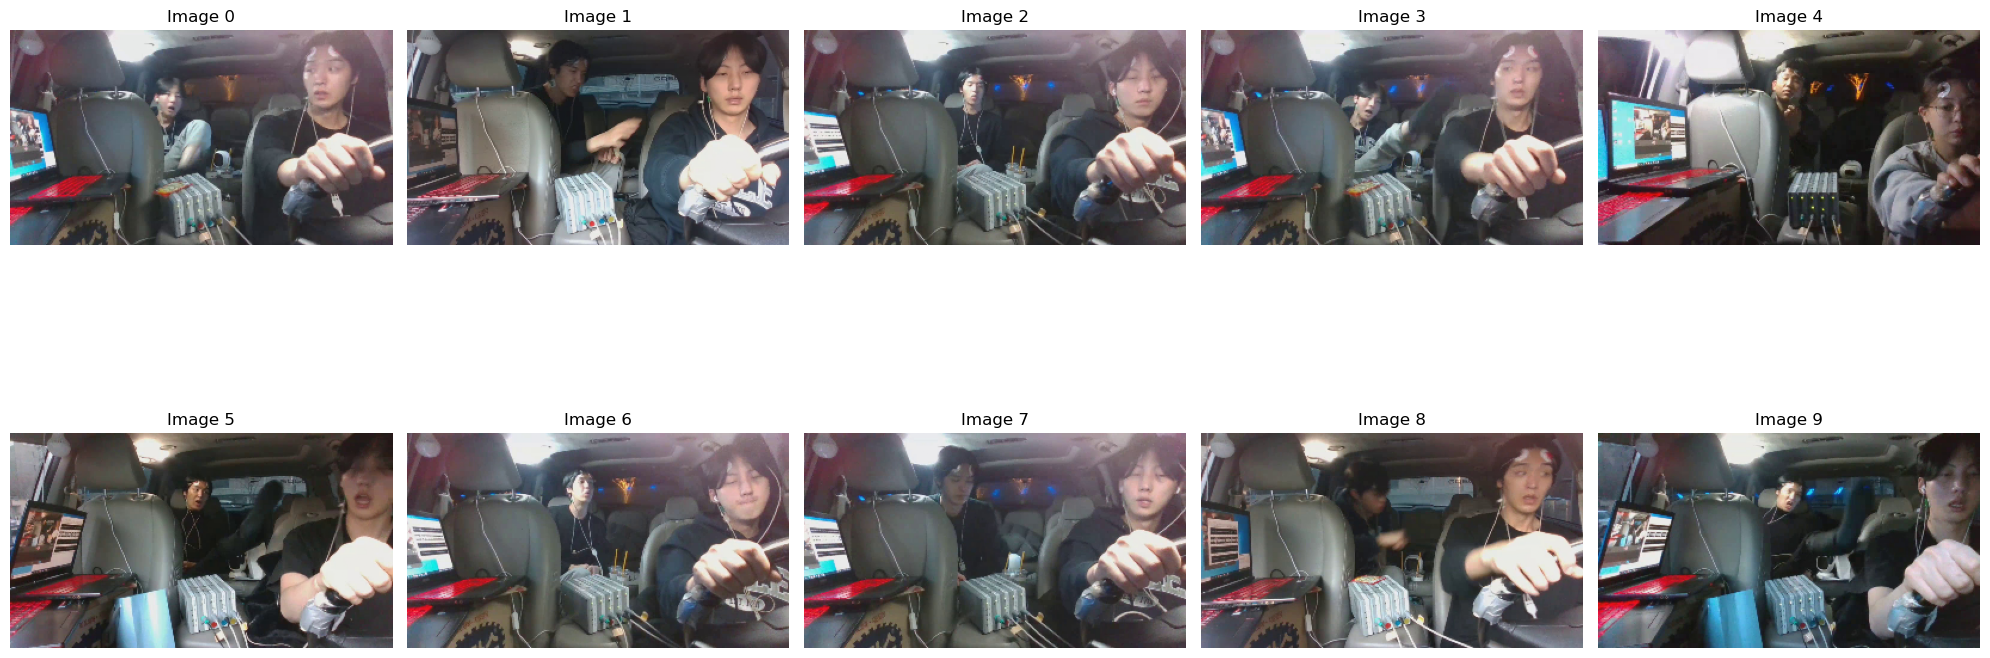

In [4]:
num_images_to_display = 10

# Set the figure size for displaying images
plt.figure(figsize=(20, 10))  # Width, height in inches

for i in range(num_images_to_display):
    # Select the i-th image from the images_np array
    img = images_np[i]
    plt.subplot(2, 5, i + 1)  # Rows, columns, index of the subplot
    plt.imshow(img)
    plt.title(f'Image {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
def normalize(df):
    scaler = MinMaxScaler()

    num_images, height, width, channels = df.shape
    images_reshaped = df.reshape(num_images, -1)

    images_normalized = scaler.fit_transform(images_reshaped)

    df = images_normalized.reshape(num_images, height, width, channels)  
    return df

In [6]:
print(images_np_valid.shape)

(4000, 180, 320, 3)


In [7]:
images_np = normalize(images_np)
images_np_valid = normalize(images_np_valid)
labels_np = labels_np.astype(int)
labels_np_valid = labels_np_valid.astype(int)
labels_np = np.eye(9)[labels_np]
labels_np_valid = np.eye(9)[labels_np_valid]

labels_np = np.argmax(labels_np, axis=1)
labels_np_valid = np.argmax(labels_np_valid, axis=1)

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 45 * 80, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 45 * 80)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터를 GPU로 옮깁니다 (만약 사용 가능한 경우).
train_images_tensor = torch.tensor(images_np).float().permute(0, 3, 1, 2).to(device)
train_labels_tensor = torch.tensor(labels_np).long().to(device)
valid_images_tensor = torch.tensor(images_np_valid).float().permute(0, 3, 1, 2).to(device)
valid_labels_tensor = torch.tensor(labels_np_valid).long().to(device)

# train_labels_tensor = torch.max(train_labels_tensor, 1)[1]
# valid_labels_tensor = torch.max(valid_labels_tensor, 1)[1]

# DataLoader를 설정합니다.
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_images_tensor, valid_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
torch.cuda.is_available()

True

Epoch 1/100 - Training Loss: 0.4580 - Validation Loss: 0.2900
Epoch 2/100 - Training Loss: 0.2479 - Validation Loss: 0.2626
Epoch 3/100 - Training Loss: 0.2036 - Validation Loss: 0.2490
Epoch 4/100 - Training Loss: 0.1815 - Validation Loss: 0.2170
Epoch 5/100 - Training Loss: 0.1633 - Validation Loss: 0.2380
Epoch 6/100 - Training Loss: 0.1459 - Validation Loss: 0.2495
Epoch 7/100 - Training Loss: 0.1278 - Validation Loss: 0.2424
Epoch 8/100 - Training Loss: 0.1140 - Validation Loss: 0.2478
Epoch 9/100 - Training Loss: 0.1019 - Validation Loss: 0.2612
Epoch 10/100 - Training Loss: 0.0838 - Validation Loss: 0.3596
Epoch 11/100 - Training Loss: 0.0787 - Validation Loss: 0.2921
Epoch 12/100 - Training Loss: 0.0665 - Validation Loss: 0.3108
Epoch 13/100 - Training Loss: 0.0604 - Validation Loss: 0.3096
Epoch 14/100 - Training Loss: 0.0539 - Validation Loss: 0.3661
Epoch 15/100 - Training Loss: 0.0509 - Validation Loss: 0.3812
Epoch 16/100 - Training Loss: 0.0427 - Validation Loss: 0.4019
E

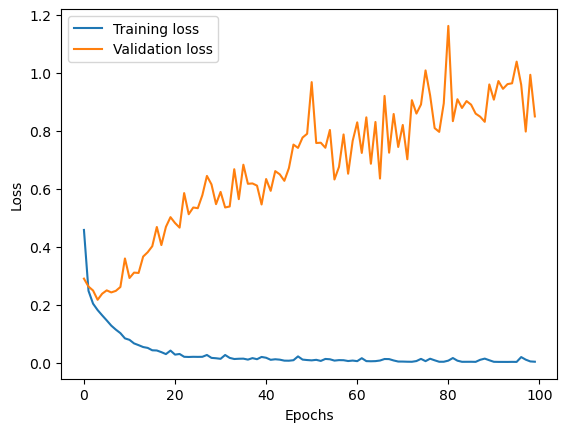

In [11]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
train_losses, valid_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    valid_losses.append(running_loss / len(valid_loader))
    print(f'Epoch {epoch+1}/{epochs} - Training Loss: {train_losses[-1]:.4f} - Validation Loss: {valid_losses[-1]:.4f}')

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()